# Answering Business Questions using SQL

Using SQL and the chinook.db database, we will create queries and visualizations of the data to draw some conclusions.

The chinook.db data is for a digital media store.  It includes the following tables:

- employee
- customer
- invoice
- invoice_line
- track
- playlist_track
- playlist
- album
- artist
- media_type
- genre

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# display plots inline
%matplotlib inline
import sqlite3
from matplotlib import cm

In [2]:
# create helper functions
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [3]:
# return a list of all of the tables and views
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## New Albums

We have a new record label deal and we can select the first three albums to add to the store.  Our choices are from the following, listing artist name and the genre:

- Regal (Hip-Hop)
- Red Tone (Punk)
- Meteor and the Girls (Pop)
- Slim Jim Bites (Blues)

We have been given funds to advertise in the USA, so we would like to choose the genres that are most popular in the USA.

In [4]:
# determine number of tracks sold for each genre
# look at absolute numbers and percentages
# limit to genres with at least 1% of the total
q1 = '''
WITH usa_tracks_sold AS
    (
    SELECT
        g.name genre_name,
        SUM(il.quantity) tracks_sold
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = 'USA'
    GROUP BY genre_name
    )
    
SELECT
    genre_name,
    tracks_sold,
    CAST(tracks_sold AS float) / 
        (SELECT SUM(tracks_sold) from usa_tracks_sold) percent_sold
FROM usa_tracks_sold
WHERE percent_sold > 0.01
ORDER BY tracks_sold DESC;
'''
run_query(q1)

,genre_name,tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


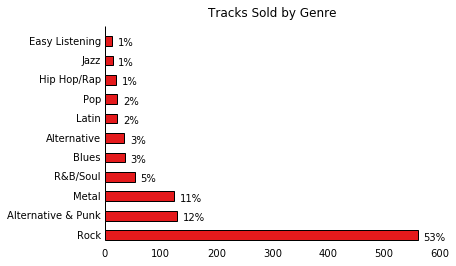

In [5]:
# create plot to visualize data
sales_by_genre_usa = run_query(q1)
sales_by_genre_usa.set_index('genre_name', inplace=True, drop=True)

ax = sales_by_genre_usa.plot.barh(
    title='Tracks Sold by Genre',
    xlim=(0,600),
    width=1.0,
    align='edge',
    legend=False,
    cmap=plt.cm.get_cmap('Set1'))
ax.set_ylabel('')
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(bottom="off", top="off", left="off", right="off")
for i, label in enumerate(list(sales_by_genre_usa.index)):
    score = sales_by_genre_usa.loc[label, 'tracks_sold']
    label = (sales_by_genre_usa.loc[label, 'percent_sold'] * 100
            ).astype(int).astype(str) + "%"
    ax.annotate(str(label), (score + 10, i))
ax.set_yticks(np.arange(0.25,11.25,1))

Given the above results of sales by genre, for our choices of Hip-Hop, Punk, Pop, and Blues, the best options are:

- Red Tone (Punk) - Alternative & Punk with 12%
- Slim Jim Bites (Blues) - Blues with 3%
- Meteor and the Girls (Pop) - Pop with 2%

Note that all three of these genres are small relative to the total catalog of options, and we have none of the Rock genre, which comprises 53% of the total sales.

## Performance of Sales Support Agents

Each customer is assigned a sales support agent when they first make a purchase.  Let's review the purchases for any outliers in the performance of these sales support agents.

We will start by looking at total sales by agent.

In [6]:
# determine total sales by agent
q2 = '''   
SELECT
    c.support_rep_id agent_id,
    e.first_name || " " || e.last_name agent_name,
    e.title agent_title,
    e.birthdate agent_birthdate,
    e.hire_date agent_hiredate,
    SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i on c.customer_id = i.customer_id
GROUP BY c.support_rep_id
ORDER BY total_sales DESC;
'''
run_query(q2)

,agent_id,agent_name,agent_title,agent_birthdate,agent_hiredate,total_sales
0,3,Jane Peacock,Sales Support Agent,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
1,4,Margaret Park,Sales Support Agent,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
2,5,Steve Johnson,Sales Support Agent,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


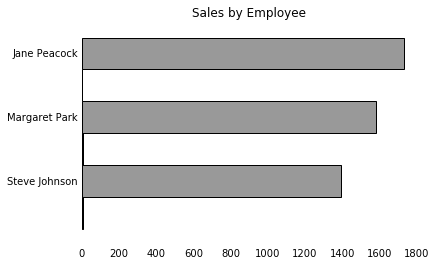

In [7]:
# create plot to visualize data
sales_by_ee = run_query(q2)
sales_by_ee.set_index('agent_name', inplace=True, drop=True)
sales_by_ee.sort_values('total_sales', inplace=True)

ax = sales_by_ee.plot.barh(
    title='Sales by Employee',
    xlim=(0,1800),
    width=1.0,
    align='center',
    legend=False,
    cmap=plt.cm.get_cmap('Set1'))
ax.set_ylabel('')
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.set_yticks(np.arange(0.25,3.25,1))

There are three Sales Support Agents.  The one with the lowest sales was hired most recently, and the one with the most sales was hired first.  The difference in sales may be due to how long each has been working.

Let's redo this query, this time looking only at sales that occurred while all three were employed.

In [8]:
q3 = '''   
WITH invoices_after AS
    (
    SELECT *
    FROM invoice i
    WHERE i.invoice_date >= '2017-10-17 00:00:00'
    )

SELECT
    c.support_rep_id agent_id,
    e.first_name || " " || e.last_name agent_name,
    e.title agent_title,
    e.birthdate agent_birthdate,
    e.hire_date agent_hiredate,
    SUM(ia.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoices_after ia on c.customer_id = ia.customer_id
GROUP BY c.support_rep_id
ORDER BY total_sales DESC;
'''
run_query(q3)

,agent_id,agent_name,agent_title,agent_birthdate,agent_hiredate,total_sales
0,3,Jane Peacock,Sales Support Agent,1973-08-29 00:00:00,2017-04-01 00:00:00,1312.74
1,4,Margaret Park,Sales Support Agent,1947-09-19 00:00:00,2017-05-03 00:00:00,1196.91
2,5,Steve Johnson,Sales Support Agent,1965-03-03 00:00:00,2017-10-17 00:00:00,1167.21


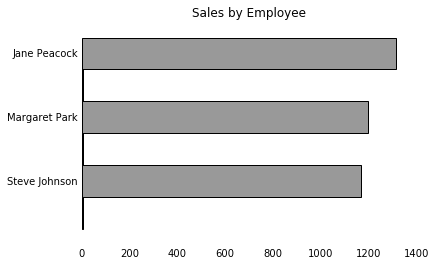

In [9]:
# create plot to visualize data
sales_by_ee_2 = run_query(q3)
sales_by_ee_2.set_index('agent_name', inplace=True, drop=True)
sales_by_ee_2.sort_values('total_sales', inplace=True)

ax = sales_by_ee_2.plot.barh(
    title='Sales by Employee',
    xlim=(0,1400),
    width=1.0,
    align='center',
    legend=False,
    cmap=plt.cm.get_cmap('Set1'))
ax.set_ylabel('')
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.set_yticks(np.arange(0.25,3.25,1))

We still see the same pattern in the data, in that the most recent hire has sold the least and the first hire has sold the most.  However, since Steve is the most recent hire, all of his customers would be newer than Jane's and Margaret's, since the agent is assigned when the customer makes the first purchase.  If established customers purchase more than newer customers, this could still explain the pattern.

Another factor may be age.  Jane is the youngest of the agents and has the largest sales.  Perhaps she is better able to connect with the customers to make sales or has music interests that better overlap with the customer base.

## Sales Data by Country

Next let's analyze the sales data by customer country.  We can review several metrics, including numbers of customers, total dollars of sales, average sales by customer, and average order value.

Note that there are several countries with only one customer.  We will group these as Other in the below analysis.

In [10]:
# let's look at which countries only have one customer
one_country_customer = '''
SELECT
    country,
    COUNT(customer_id) count
FROM customer
GROUP BY country
HAVING count = 1;
'''
run_query(one_country_customer)

,country,count
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


In [11]:
# create query to view all of the info described above

q4 = '''
WITH orders_by_customer AS
    (
    SELECT
        customer_id,
        COUNT(customer_id) order_count,
        SUM(total) total_sales
    FROM invoice
    GROUP BY customer_id
    ),
    customer_country AS
    (
        WITH one_cust AS
        (
        SELECT
            country,
            COUNT(customer_id) count
        FROM customer
        GROUP BY country
        )

    SELECT
        CASE
            WHEN oc.count = 1 THEN 'Other'
            ELSE c.country
        END AS country_updated,
        c.customer_id
    FROM customer c
    LEFT JOIN one_cust oc ON c.country = oc.country
    )

SELECT
    cc.country_updated country,
    COUNT(cc.customer_id) num_customers,
    SUM(obc.total_sales) sales,
    SUM(obc.order_count) orders,
    CAST(SUM(obc.total_sales) AS float)/
        CAST(COUNT(cc.customer_id) AS float) avg_sales_customer,
    CAST(SUM(obc.total_sales) AS float)/
        CAST(SUM(obc.order_count) AS float) avg_order_value,
    CASE
        WHEN cc.country_updated = 'Other' THEN 1
        ELSE 0
    END AS sort
FROM customer_country cc
INNER JOIN orders_by_customer obc ON cc.customer_id = obc.customer_id
GROUP BY cc.country_updated
ORDER BY sort ASC, sales DESC;
'''
run_query(q4)

,country,num_customers,sales,orders,avg_sales_customer,avg_order_value,sort
0,USA,13,1040.49,131,80.037692,7.942672,0
1,Canada,8,535.59,76,66.948750,7.047237,0
2,Brazil,5,427.68,61,85.536000,7.011148,0
3,France,5,389.07,50,77.814000,7.781400,0
4,Germany,4,334.62,41,83.655000,8.161463,0
5,Czech Republic,2,273.24,30,136.620000,9.108000,0
6,United Kingdom,3,245.52,28,81.840000,8.768571,0
7,Portugal,2,185.13,29,92.565000,6.383793,0
8,India,2,183.15,21,91.575000,8.721429,0
9,Other,15,1094.94,147,72.996000,7.448571,1


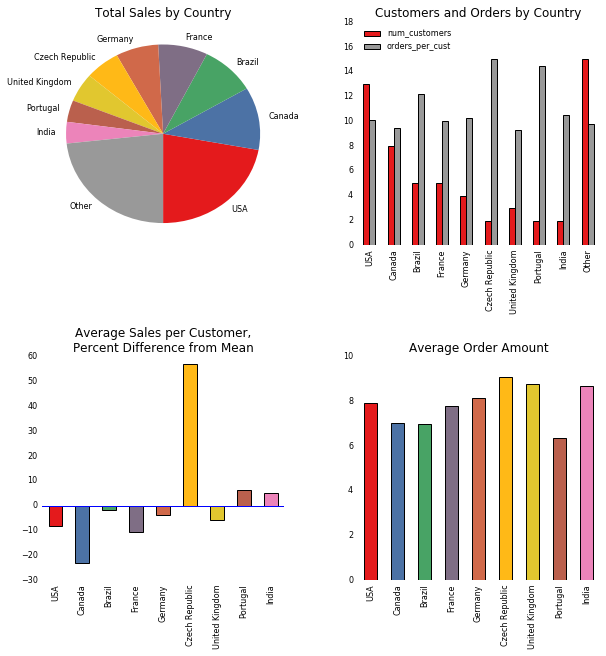

In [12]:
# create visualizations of the data by country

sales_data_by_country = run_query(q4)
sales_data_by_country.set_index('country', inplace=True, drop=True)
colors = [plt.cm.Set1(i) for i in np.linspace(0, 1, sales_data_by_country.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left - sales by country
sales_data_by_country.plot.pie(
    y='sales', 
    ax=axes[0,0],
    title='Total Sales by Country',
    legend=False,
    cmap=plt.cm.get_cmap('Set1'),
    startangle=270,
    fontsize=8,
    wedgeprops={'linewidth':0}
    )
axes[0,0].set_ylabel('')

# top right - customers and orders by country
cust_cols = ['num_customers','orders']
cust_orders = sales_data_by_country[cust_cols].copy()
cust_orders['orders_per_cust'] = cust_orders['orders']/cust_orders['num_customers']
cust_orders=cust_orders.drop(['orders'], axis=1)

cust_orders.plot.bar(
    ax=axes[0,1],
    cmap=plt.cm.get_cmap('Set1'),
    ylim=(0,18),
    fontsize=8,
    title='Customers and Orders by Country'
    )
axes[0,1].set_xlabel('')
for key,spine in axes[0,1].spines.items():
        spine.set_visible(False)
axes[0,1].tick_params(bottom="off", top="off", left="off", right="off")
axes[0,1].legend(loc=2, frameon=False, prop={'size':8})

# bottom left - average sales per customer
avg_sales = sales_data_by_country['avg_sales_customer'].copy()
diff_from_mean = avg_sales * 100 / avg_sales.mean() - 100
diff_from_mean.drop('Other', inplace=True)
diff_from_mean.plot.bar(
    ax=axes[1,0],
    fontsize=8,
    title='Average Sales per Customer,\nPercent Difference from Mean',
    color=colors
    )
axes[1,0].set_xlabel('')
for key,spine in axes[1,0].spines.items():
        spine.set_visible(False)
axes[1,0].tick_params(bottom="off", top="off", left="off", right="off")
axes[1,0].axhline(y=0)

#bottom right - average order value
avg_order = sales_data_by_country['avg_order_value'].copy()
avg_order.drop('Other', inplace=True)
avg_order.plot.bar(
    ax=axes[1,1],
    fontsize=8,
    title='Average Order Amount',
    color=colors
    )
axes[1,1].set_xlabel('')
for key,spine in axes[1,1].spines.items():
        spine.set_visible(False)
axes[1,1].tick_params(bottom="off", top="off", left="off", right="off")

Based on the above, it appears that customers from the Czech Republic, Portugal, and India have the largest sales per customer, so these countries appear to be good targets for growth.

However, there are not a lot of customers in these countries - our sample size is small.  As we obtain more customers in these countries, these patterns may not continue to hold.  Any action on this data should be monitored closely.

## Albums vs. Individual Tracks

Management is considering changing how they purchase tracks.  They would like more information on the percentage of purchases that are individual tracks versus purchasing an entire album.  Should the company continue to buy entire albums, or change to only purchasing the most popular tracks?

In [13]:
q5 = '''
WITH invoice_tracks AS
    (
    SELECT
        il.invoice_id,
        il.track_id,
        t.album_id
    FROM invoice_line il
    INNER JOIN track t ON il.track_id = t.track_id
    ),
    
    album_tracks AS
    (
    SELECT
        album_id,
        COUNT(DISTINCT track_id) num_tracks
    FROM track
    GROUP BY album_id
    ),
    
    albums_purchased AS
    (
    SELECT
        it.invoice_id,
        CASE
            WHEN
                (COUNT(DISTINCT it.album_id) = 1
                 AND
                 COUNT(DISTINCT it.track_id) = at.num_tracks
                 ) THEN 1
            ELSE 0 
            END AS album_purchase
    FROM invoice_tracks it
    LEFT JOIN album_tracks at ON at.album_id=it.album_id
    GROUP BY invoice_id
    )

SELECT
    album_purchase,
    COUNT(invoice_id) num_invoices,
    CAST(COUNT(invoice_id) AS float) * 100 / 
        CAST((SELECT COUNT(invoice_id) FROM albums_purchased) AS float)
        percent
FROM albums_purchased
GROUP BY album_purchase
'''
run_query(q5)

,album_purchase,num_invoices,percent
0,0,500,81.433225
1,1,114,18.566775


From the above statistics, it appears that 500 of the 614 invoices, about 81%, are purchases of individual tracks rather than entire albums.  About 19% of the invoices are puchases of entire albums.  

To determine whether management should proceed, we need to know how much money would be saved.  This change would cut out 19% of the number of purchases made at the company.  If costs are reduced enough by implementing this change, this could be more profitable for the company.

However, there are additional impacts to consider.  If some customers use Chinook because of the ability to buy full albums and this ability is taken away, they may lose customers.

Further analysis incorporating the expected cost savings and expected revenue reduction is needed (but is beyond the scope of the data we have now).